# Pattern Driven Stock Analysis

Finding Similar Stocks using Graph Analytis in Neo4j.


# Steps

1. Import Stock Data into Neo4j
2. Create [:NEXT] relationship property between nodes
3. Find KNN similarity using trade volume among nodes: Create [:SIMILAR_KNN_VOLUME]  relationship among PRICE Nodes
4. Community detection based on Louvain algorithm using [:SIMILAR_KNN_VOLUME] relationship: Create VolumeCommunity property
5. Hierarchical Structures Communities using Label Propagation Algorithm

In [2]:
import os
%load_ext dotenv
%dotenv

NEO4J_HOST=os.getenv("NEO4J_HOST")
NEO4J_USER=os.getenv("NEO4J_USER")
NEO4J_PASSWORD=os.getenv("NEO4J_PASSWORD")
STOCK_DATA=os.getenv("STOCK_DATA")

### Import Stock Data into Neo4j

Using NASDAQ Data from: https://www.kaggle.com/datasets/kalilurrahman/nasdaq100-stock-price-data

In [4]:
import pandas as pd

DATA_FILE_NAME = 'NASDAQ_100_Data_From_2010.csv'
NASDAQ_DF = pd.read_csv('{path}/{file}'.format(path=STOCK_DATA,file=DATA_FILE_NAME),delimiter='\t')
NASDAQ_DF

,Date,Open,High,Low,Close,Adj Close,Volume,Name
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.562591,493729600,AAPL
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.573935,601904800,AAPL
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.469369,552160000,AAPL
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.457407,477131200,AAPL
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.500339,447610800,AAPL
...,...,...,...,...,...,...,...,...
271675,2021-09-03,295.325012,301.804993,292.029999,298.290009,298.290009,6127900,ZM
271676,2021-09-07,298.295013,300.980011,294.799988,299.959991,299.959991,4251900,ZM
271677,2021-09-08,299.549988,299.959991,290.529999,293.600006,293.600006,3934400,ZM
271678,2021-09-09,292.160004,297.570007,291.130005,295.859985,295.859985,3350100,ZM


In [6]:
# CONNECT NEO4j
from neo4j import GraphDatabase

uri = "bolt://{host}:7687".format(host=NEO4J_HOST)

with GraphDatabase.driver(uri, auth=(NEO4J_USER, NEO4J_PASSWORD)) as driver: 
    driver.verify_connectivity() 
    session = driver.session(database='')
    
def cypher_run(cypher):
    result = session.run(cypher)
    return result.to_df()

def cypher_run_g(cypher):
    result = session.run(cypher)
    return result.graph()


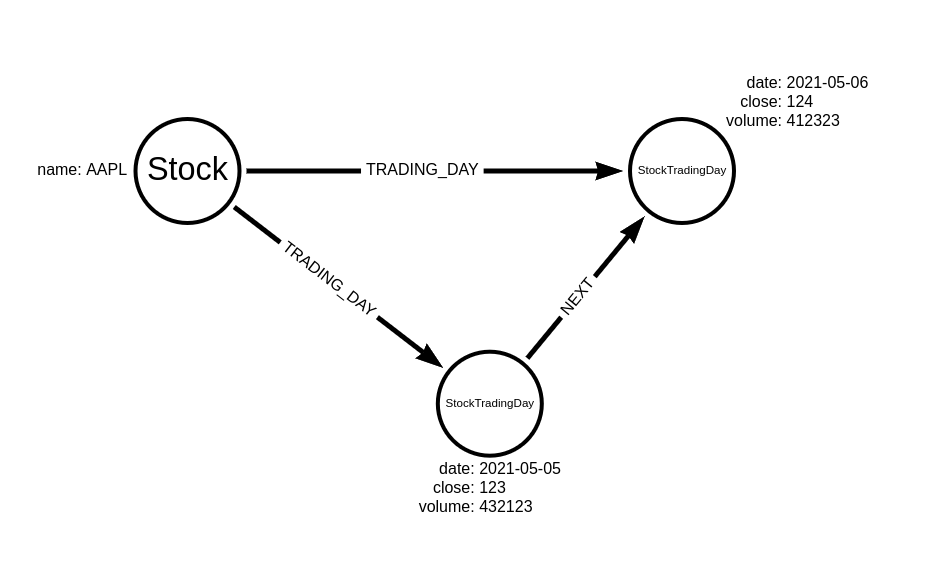

Create 'Stock' nodes

In [12]:
NASDAQ_DF["Name"].drop_duplicates().to_csv('{path}/{file}'.format(path=STOCK_DATA,file="stock_names.csv"))

In [13]:
q = """
LOAD CSV WITH HEADERS FROM 'http://fileserver:4858/NASDAQ_DATA/NASDAQ_100_Data_From_2010.csv' AS row
MERGE (s:Stock {id:row.Name})
"""
cypher_run(q)

""


In [14]:
q="""
MATCH (n:Stock) RETURN COUNT(n);
"""
cypher_run(q)

,COUNT(n)
0,102


TODO: 
1. Create 'StockTradingDay' nodes
2. Add TRADING_DAY relationship between Stock and Trading day

In [ ]:
q = """
LOAD CSV WITH HEADERS FROM 'http://fileserver:4858/NASDAQ_DATA/stock_names.csv' AS row
MERGE (s:Stock {id:row.Name})
"""
cypher_run(q)

Create [:NEXT] relationship property between nodes

In [ ]:
  # Create NEXT relationship between encounters of a patient
q = """
    CALL apoc.periodic.iterate(
    'MATCH (p:Patient) RETURN p',
    'MATCH (p)-[:HAS_ENCOUNTER]->(e)
    WITH e
    ORDER BY e.date
    WITH collect(e) AS encounters
    WITH encounters, encounters[1..] as nextEncounters
    UNWIND range(0,size(nextEncounters)-1,1) as index
    WITH encounters[index] as first, nextEncounters[index] as second
    CREATE (first)-[:NEXT]->(second)',{iterateList:false});
    
    """
cypher_run(q)

### KNN
Find KNN similarity using trade volume among nodes, using [:SIMILAR_KNN_VOLUME] relationship among PRICE Nodes

In [ ]:
query = """

CALL gds.nodeSimilarity.write.estimate('northwindGraph1', {
  writeRelationshipType: 'SIMILAR',
  writeProperty: 'score'
})
YIELD nodeCount, relationshipCount, bytesMin, bytesMax, requiredMemory

"""

In [ ]:
query = """
CALL gds.nodeSimilarity.stream('northwindGraph1')
YIELD node1, node2, similarity
RETURN gds.util.asNode(node1).customerID AS customer1, gds.util.asNode(node2).customerID AS customer2, similarity
ORDER BY similarity DESCENDING, customer1, customer2
"""

cypher_run(query)

### Community detection
Using Louvain algorithm on [:SIMILAR_KNN_VOLUME] relationship to Create VolumeCommunity property

In [3]:
# https://neo4j.com/docs/graph-data-science/current/algorithms/louvain/

### Label Propagation Algorithm
Hierarchical Structures Communities using

In [2]:
# https://neo4j.com/docs/graph-data-science/current/algorithms/label-propagation/